In [40]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import warnings

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings("ignore")

In [2]:
test_df = pd.read_csv("datasets/test.csv")
train_df = pd.read_csv("datasets/train.csv")
sample_submission =pd.read_csv("datasets/sample_submission.csv")

# Veri Önişleme


In [3]:
def check_df(df):
    """
    :param df: genel bakış atmak istediğimiz dataframe
    :return: None
    """
    print("**** Genel Bilgiler ****")
    print(df.info())
    print("**** Eksik değer var mı ****")
    print(df.isna().sum())
    print("**** ilk beş değer ****")
    print(df.head())
    print("**** son beş değer ****")
    print(df.tail())

In [4]:
check_df(train_df)

**** Genel Bilgiler ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312696 entries, 0 to 312695
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DATETIME  312696 non-null  object 
 1   SERVER    312696 non-null  object 
 2   CPU       312696 non-null  object 
 3   CPULOAD   312696 non-null  float64
dtypes: float64(1), object(3)
memory usage: 9.5+ MB
None
**** Eksik değer var mı ****
DATETIME    0
SERVER      0
CPU         0
CPULOAD     0
dtype: int64
**** ilk beş değer ****
                    DATETIME     SERVER     CPU  CPULOAD
0  2020-03-24 00:00:00+03:00  CIHAZ_301   CPU-0     3.88
1  2020-03-24 00:00:00+03:00  CIHAZ_301   CPU-1    11.33
2  2020-03-24 00:00:00+03:00  CIHAZ_301  CPU-10     5.31
3  2020-03-24 00:00:00+03:00  CIHAZ_301  CPU-11     5.25
4  2020-03-24 00:00:00+03:00  CIHAZ_301  CPU-12     0.28
**** son beş değer ****
                         DATETIME     SERVER    CPU  CPULOAD
312691  2020-05-30 

* Veri setinin 3 kategorik 1 sayısal değişkenden oluştuğunu görüyoruz. veri setinde herhangi eksik değer bulunmuyor.
* içerik olarak datetime türünde olan DATETİME değişkeninin str formattan dönüştürülmesi gerekiyor. ayrıca model kurulma aşamasında sorun yaşamamak için time zone belirten değerleri de çıkarmak gerekir


In [5]:
#datatime değişkenin türünü dönüştürme
train_df['DATETIME'] = pd.to_datetime(train_df['DATETIME'], format='%Y-%m-%dT%H:%M')
train_df['DATETIME'] = train_df['DATETIME'].dt.tz_localize(None)
test_df['DATETIME'] = pd.to_datetime(test_df['DATETIME'], format='%Y-%m-%dT%H:%M')
test_df['DATETIME'] = test_df['DATETIME'].dt.tz_localize(None)

In [6]:
train_df["SERVER"].value_counts()
#veri setinde iki cihaz için ayrı ayrı değerler tutuluyor

CIHAZ_301    156360
CIHAZ_305    156336
Name: SERVER, dtype: int64

In [7]:
train_df["CPU"].value_counts()

CPU-0     13029
CPU-1     13029
CPU-8     13029
CPU-7     13029
CPU-6     13029
CPU-5     13029
CPU-4     13029
CPU-3     13029
CPU-23    13029
CPU-22    13029
CPU-21    13029
CPU-20    13029
CPU-2     13029
CPU-19    13029
CPU-18    13029
CPU-17    13029
CPU-16    13029
CPU-15    13029
CPU-14    13029
CPU-13    13029
CPU-12    13029
CPU-11    13029
CPU-10    13029
CPU-9     13029
Name: CPU, dtype: int64

* veriseti 12 şer CPU dan oluşan iki Serverın CPULOAD değerlerini içermektedir.
* amaç CPULOAD değerlerini cihazlar özelinde incelemek olduğu için cihazların CPU ortalamalarını almak uygundur

In [8]:
#serverları ayrı değerlendirmek için df leri ayırma
server_305 = train_df[train_df["SERVER"]=="CIHAZ_305"]
server_301 = train_df[train_df["SERVER"]=="CIHAZ_301"]

In [9]:
server_305 = server_305.groupby(["DATETIME"]).agg({"CPULOAD":"mean"})
server_301 = server_301.groupby(["DATETIME"]).agg({"CPULOAD":"mean"})

In [10]:
#nihai veri setini inceleme
check_df(server_301)
check_df(server_305)

**** Genel Bilgiler ****
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6515 entries, 2020-03-24 00:00:00 to 2020-05-30 23:45:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CPULOAD  6515 non-null   float64
dtypes: float64(1)
memory usage: 101.8 KB
None
**** Eksik değer var mı ****
CPULOAD    0
dtype: int64
**** ilk beş değer ****
                      CPULOAD
DATETIME                     
2020-03-24 00:00:00  4.425000
2020-03-24 00:15:00  4.427500
2020-03-24 00:30:00  3.910417
2020-03-24 00:45:00  3.633750
2020-03-24 01:00:00  3.575000
**** son beş değer ****
                      CPULOAD
DATETIME                     
2020-05-30 22:45:00  9.213333
2020-05-30 23:00:00  6.367083
2020-05-30 23:15:00  6.102083
2020-05-30 23:30:00  5.930833
2020-05-30 23:45:00  5.656250
**** Genel Bilgiler ****
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6514 entries, 2020-03-24 00:00:00 to 2020-05-30 23:45:00
Data columns (

In [11]:
def plot(df):
    """
    ortalaması alınan cpuload değişkenine zaman değişkeniyle birlikte grafikte görme
    :param df: incelenmek istenen df
    :return: None
    """
    plt.figure(figsize=(25,10))
    plt.plot(df.index, df["CPULOAD"])
    plt.xlabel("Tarih")
    plt.ylabel("CPULOAD")
    plt.show()

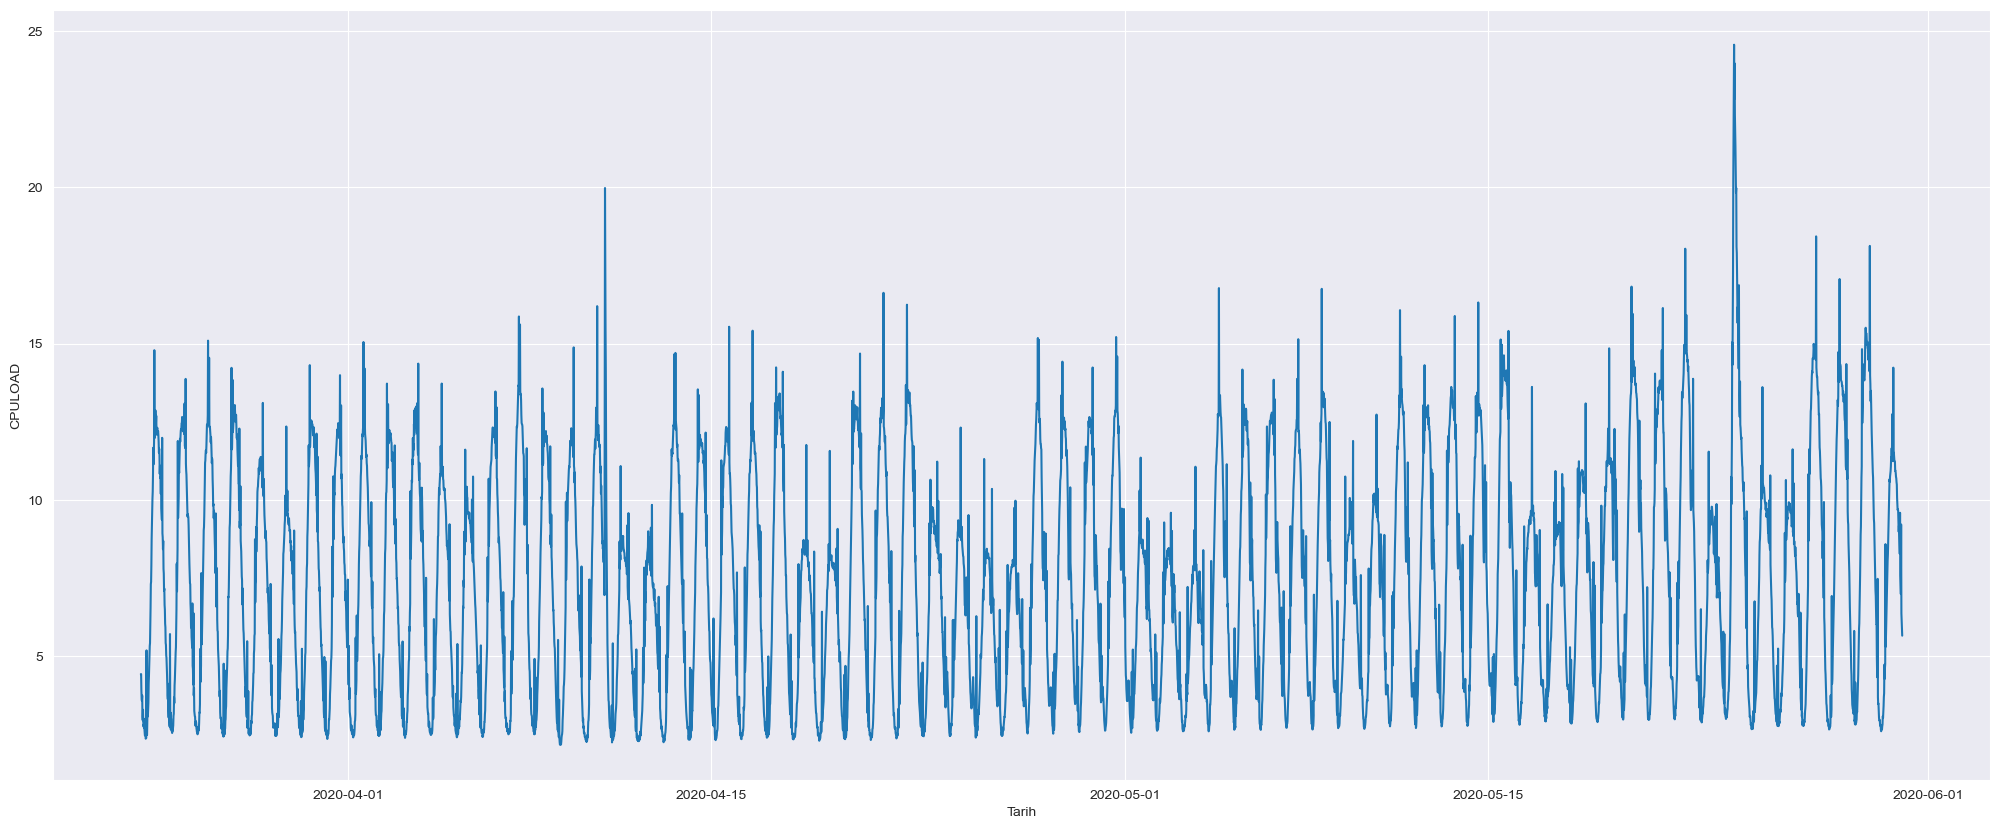

In [12]:
plot(server_301)

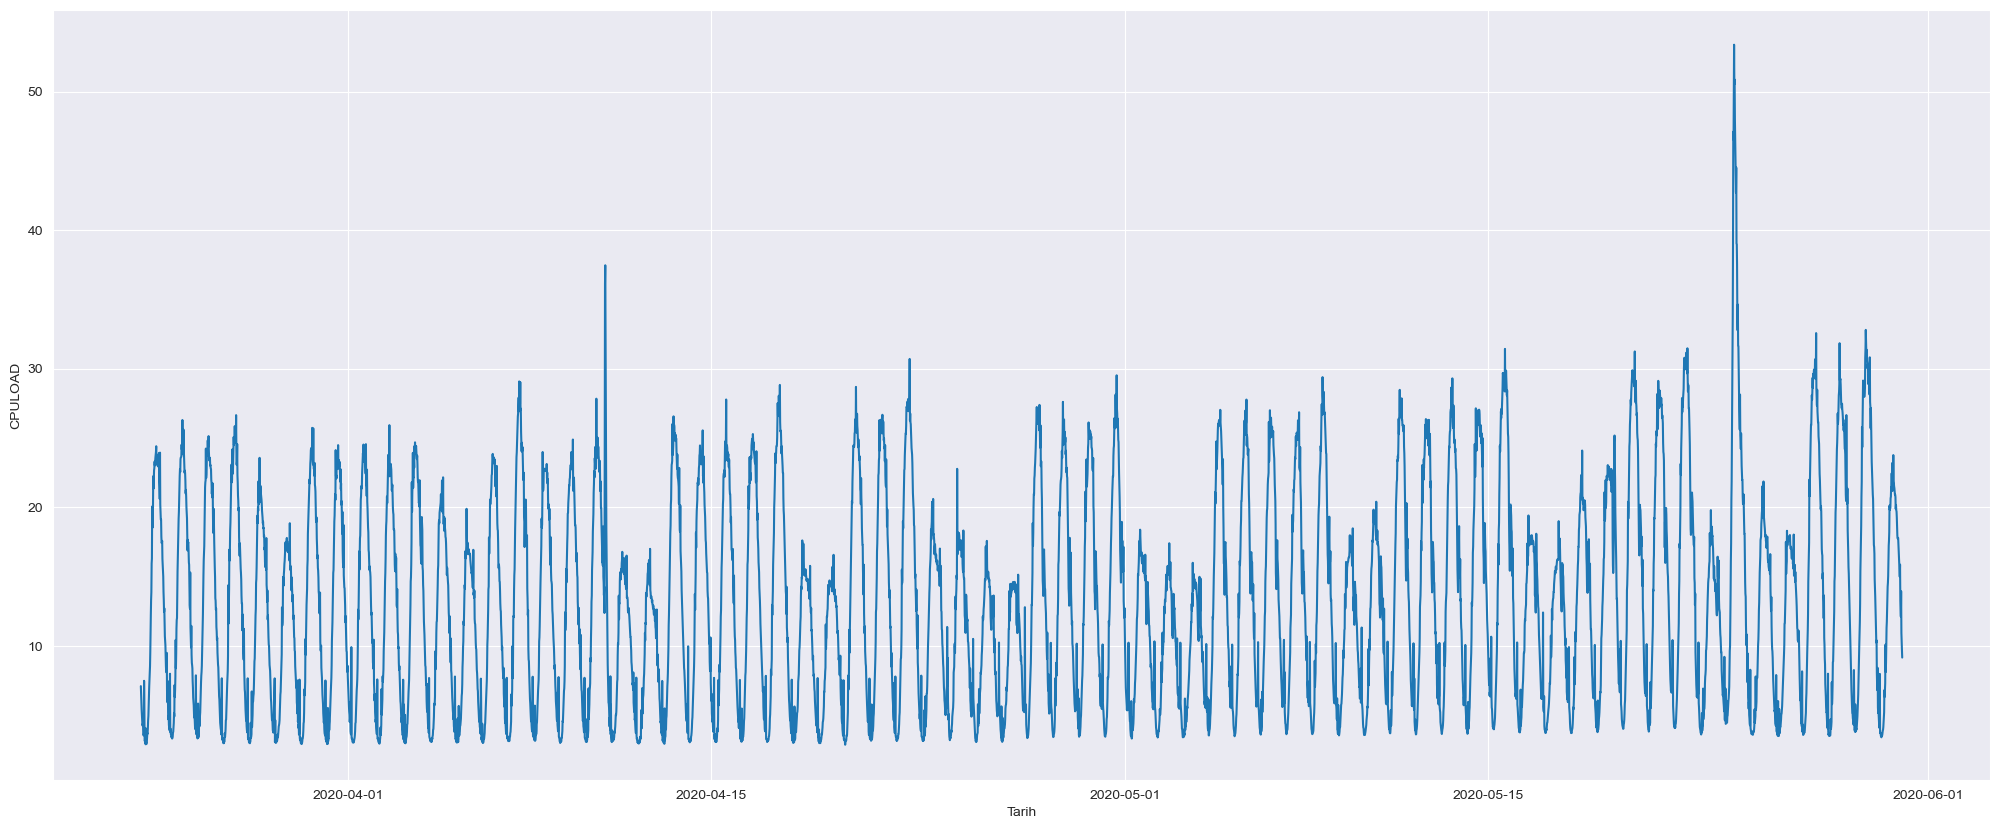

In [13]:
plot(server_305)

* iki cihazın verilerine de bakıldığında belirgin bir trend olmadığını,mevsimsellik patternleri barındırdığını düşünüyoruz
* ayrıca iki seride de bazı anomaliler olduğu göze çarpıyor


# Feature engineering

In [14]:
server_301.reset_index(inplace=True)
server_305.reset_index(inplace=True)

In [15]:
def categorize_hour(hour):
    """
    df e de oluşturulan saat değişkenine göre gündüz akşam ve gece olmak üzere 3 farklı kategori tanımlama
    :param hour: kategorize edilecek saat
    :return: saate uygun kategori
    """
    if hour < 8:
        return 'Night'
    elif hour < 16:
        return 'Day'
    else:
        return 'Evening'

In [16]:
def time_features(df):
    """
    datetime isimli değişkene göre farklı zaman featurları türetme
    day = ayın hangi günü
    hour  =günün hangi saati
    hourcategory = günün hangi zaman dilimi
    :param df: işlem yapılmak istenen dataframe
    :return: işlem yapılan dataframe
    """
    df["day"] = df["DATETIME"].dt.day
    df["hour"] = df["DATETIME"].dt.hour
    df['hourcategory'] = df['hour'].apply(categorize_hour)
    return df

In [17]:
server_301 = time_features(server_301)
server_305 = time_features(server_305)

In [18]:
check_df(server_305)

**** Genel Bilgiler ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6514 entries, 0 to 6513
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATETIME      6514 non-null   datetime64[ns]
 1   CPULOAD       6514 non-null   float64       
 2   day           6514 non-null   int64         
 3   hour          6514 non-null   int64         
 4   hourcategory  6514 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 254.6+ KB
None
**** Eksik değer var mı ****
DATETIME        0
CPULOAD         0
day             0
hour            0
hourcategory    0
dtype: int64
**** ilk beş değer ****
             DATETIME   CPULOAD  day  hour hourcategory
0 2020-03-24 00:00:00  7.084167   24     0        Night
1 2020-03-24 00:15:00  6.490833   24     0        Night
2 2020-03-24 00:30:00  5.668750   24     0        Night
3 2020-03-24 00:45:00  5.371250   24     0        N

# istatistikler

In [19]:
#oluşturulan saatlik kategorilere göre cpuload değerinin ortalamasını standart sapmasını min ve max değerlerini görelim
server_301.groupby("hourcategory")["CPULOAD"].agg(["mean", "std","min","max"])

,mean,std,min,max
hourcategory,,,,
Day,9.475408,3.181892,2.977083,24.563333
Evening,9.017574,2.403669,4.427917,19.978333
Night,3.535807,0.985469,2.166667,9.037083


In [20]:
#oluşturulan saatlik kategorilere göre cpuload değerinin ortalamasını standart sapmasını min ve max değerlerini görelim
server_305.groupby("hourcategory")["CPULOAD"].agg(["mean", "std","min","max"])

,mean,std,min,max
hourcategory,,,,
Day,17.805932,7.147844,4.028750,53.384583
Evening,16.673454,5.260660,7.188750,37.463333
Night,5.155991,1.748234,2.855833,13.765417


In [21]:
def cat_plotting(df):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Her bir subplot için histogram çizimi
    for i, category in enumerate(["Day", "Night", "Evening"]):
        ax = axs[i]
        df[df["hourcategory"] == category]["CPULOAD"].plot.hist(ax=ax)
        ax.set_title(category)

    # Legend ekleme
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    # Grafikleri gösterme
    plt.tight_layout()
    plt.show()


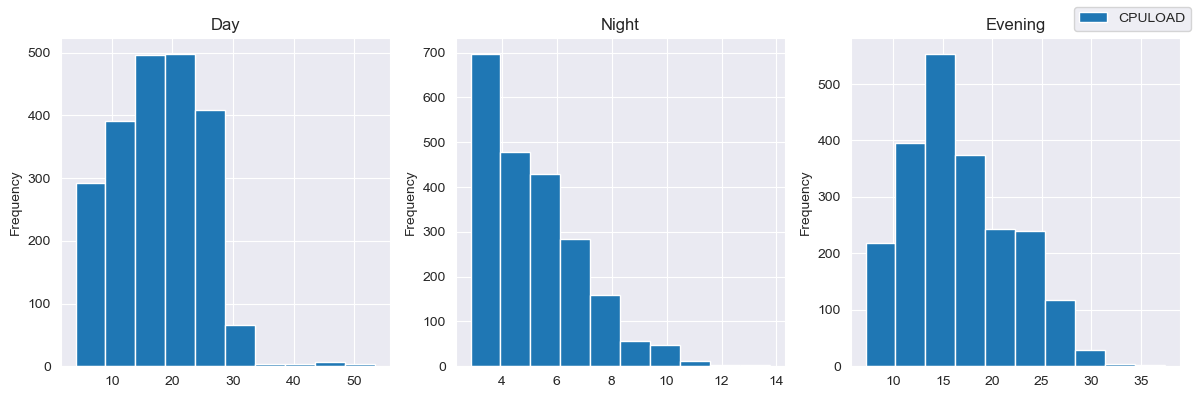

In [22]:
cat_plotting(server_305)

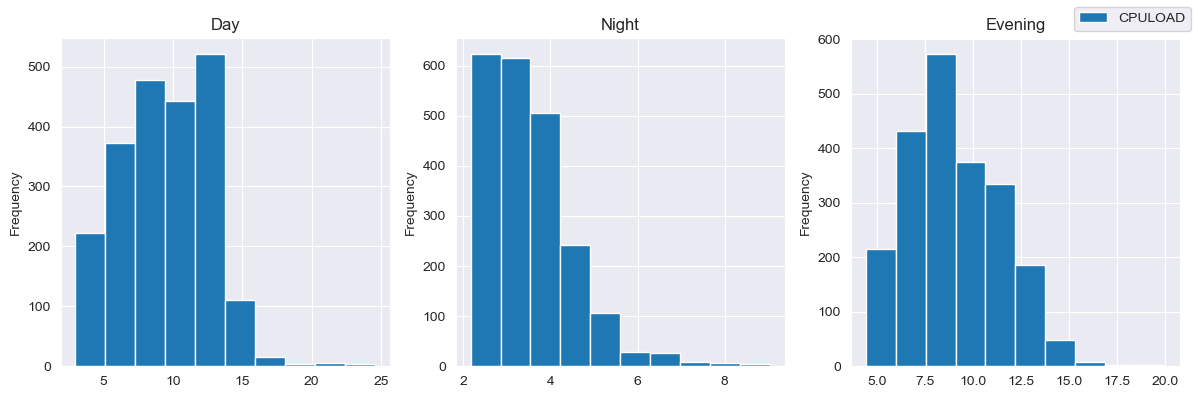

In [23]:
cat_plotting(server_301)

In [24]:
def weekend_c(df):
    """
    haftanın günlerine hafta içi olup olmama durumunu yeni bir değişken olarak türetelim
    :param df: işlem yapılmak istenen dataframe
    :return: işlem yapılan Dataframe
    """
    df['day_name'] = df['DATETIME'].dt.day_name()
    df['weekday'] = df['day_name'].apply(lambda x: True if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else False)
    return df


In [25]:
server_301 = weekend_c(server_301)
server_305 = weekend_c(server_305)

In [26]:
#hafta içi ve hafta sonu için ortalama ve standart sapma değerlerini gözlemleyelim
print(f"server_301 için haftaiçi cpuload ortalaması : {server_301[server_301['weekday'] == True]['CPULOAD'].mean()}")
print(f"server_301 için haftasonu cpuload ortalaması : {server_301[server_301['weekday'] == False]['CPULOAD'].mean()}")
print(f"server_301 için haftaiçi cpuload standart sapması : {server_301[server_301['weekday'] == True]['CPULOAD'].std()}")
print(f"server_301 için haftasonu cpuload standart sapması : {server_301[server_301['weekday'] == False]['CPULOAD'].std()}")


server_301 için haftaiçi cpuload ortalaması : 7.721097775175645
server_301 için haftasonu cpuload ortalaması : 6.380549596626329
server_301 için haftaiçi cpuload standart sapması : 3.7258812937661507
server_301 için haftasonu cpuload standart sapması : 3.013848247740928


In [27]:
#hafta içi ve hafta sonu için ortalama ve standart sapma değerlerini gözlemleyelim
print(f"server_305 için haftaiçi cpuload ortalaması : {server_305[server_305['weekday'] == True]['CPULOAD'].mean()}")
print(f"server_305 için haftasonu cpuload ortalaması : {server_305[server_305['weekday'] == False]['CPULOAD'].mean()}")
print(f"server_305 için haftaiçi cpuload standart sapması : {server_305[server_305['weekday'] == True]['CPULOAD'].std()}")
print(f"server_305 için haftasonu cpuload standart sapması : {server_305[server_305['weekday'] == False]['CPULOAD'].std()}")


server_305 için haftaiçi cpuload ortalaması : 14.092916932624112
server_305 için haftasonu cpuload ortalaması : 10.96311328555678
server_305 için haftaiçi cpuload standart sapması : 8.042232740278008
server_305 için haftasonu cpuload standart sapması : 6.365855864857117


In [28]:
def predict_SMA(df, window=16):
    """
    #girilen gecikme sayısı ile hareketli ortalama hesabını değişken olarak ekleme
    :param df: işlem yapılmak istenen dataframe
    :param window: basit hareketli ortalama için gecikme sayısı default = 16 (4 saatlik)
    :return: işlem yapılan df
    """


    df[f"sma_{window}"] = df['CPULOAD'].rolling(window=window).mean()

    plt.figure(figsize=(25, 10))
    plt.plot(df['DATETIME'].tail(1000), df['CPULOAD'].tail(1000), label='Gerçek Değerler')
    plt.plot(df['DATETIME'].tail(1000), df[f"sma_{window}"].tail(1000), label='Hareketli Ortalama')
    plt.xlabel('Tarih')
    plt.ylabel('Değer')
    plt.title('Hareketli Ortalama ve Gerçek Değerler')
    plt.legend()
    plt.show()
    return df

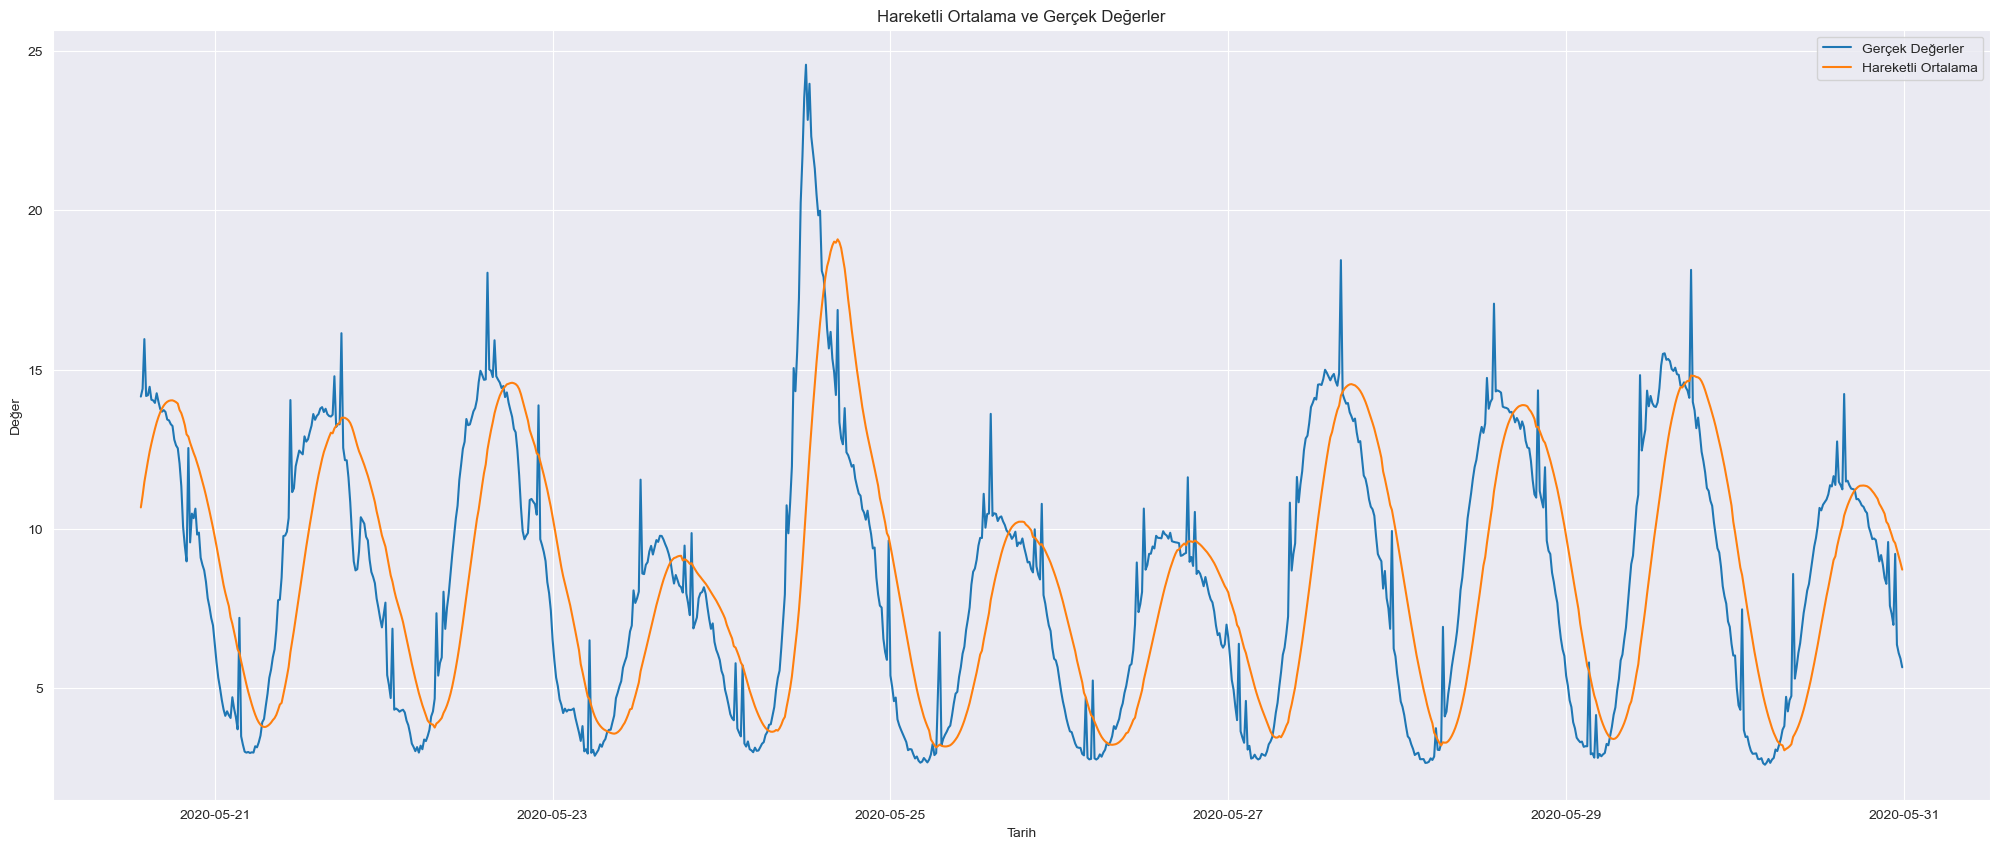

,DATETIME,CPULOAD,day,hour,hourcategory,day_name,weekday,sma_24
0,2020-03-24 00:00:00,4.425000,24,0,Night,Tuesday,True,NaN
1,2020-03-24 00:15:00,4.427500,24,0,Night,Tuesday,True,NaN
2,2020-03-24 00:30:00,3.910417,24,0,Night,Tuesday,True,NaN
3,2020-03-24 00:45:00,3.633750,24,0,Night,Tuesday,True,NaN
4,2020-03-24 01:00:00,3.575000,24,1,Night,Tuesday,True,NaN
...,...,...,...,...,...,...,...,...
6510,2020-05-30 22:45:00,9.213333,30,22,Evening,Saturday,False,9.550399
6511,2020-05-30 23:00:00,6.367083,30,23,Evening,Saturday,False,9.348003
6512,2020-05-30 23:15:00,6.102083,30,23,Evening,Saturday,False,9.146788
6513,2020-05-30 23:30:00,5.930833,30,23,Evening,Saturday,False,8.938264


In [29]:
predict_SMA(server_301,24)


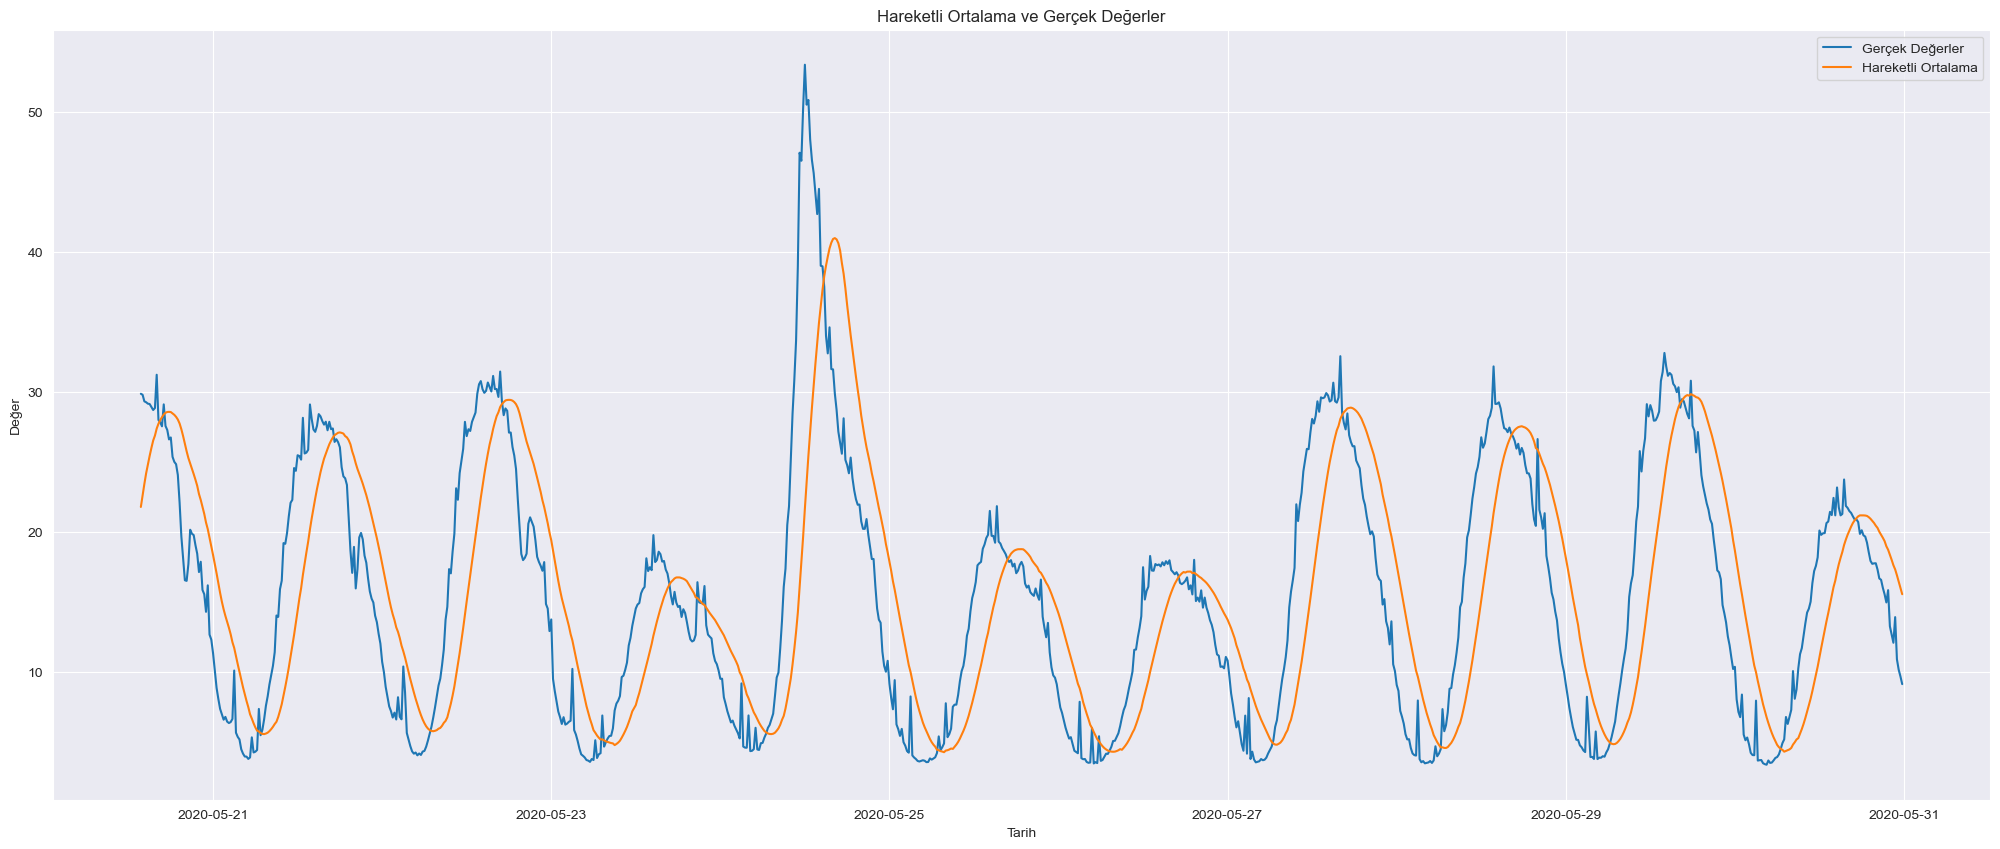

,DATETIME,CPULOAD,day,hour,hourcategory,day_name,weekday,sma_24
0,2020-03-24 00:00:00,7.084167,24,0,Night,Tuesday,True,NaN
1,2020-03-24 00:15:00,6.490833,24,0,Night,Tuesday,True,NaN
2,2020-03-24 00:30:00,5.668750,24,0,Night,Tuesday,True,NaN
3,2020-03-24 00:45:00,5.371250,24,0,Night,Tuesday,True,NaN
4,2020-03-24 01:00:00,5.005417,24,1,Night,Tuesday,True,NaN
...,...,...,...,...,...,...,...,...
6509,2020-05-30 22:45:00,13.932917,30,22,Evening,Saturday,False,17.339132
6510,2020-05-30 23:00:00,10.920833,30,23,Evening,Saturday,False,16.922969
6511,2020-05-30 23:15:00,10.177917,30,23,Evening,Saturday,False,16.475747
6512,2020-05-30 23:30:00,9.696667,30,23,Evening,Saturday,False,16.016215


In [30]:
predict_SMA(server_305,24)

In [31]:
def predict_std(df, window=16):
    """
    girilen gecikme sayısına göre standart sapma değerini değişken olarak ekleme
    :param df: işlem yapılmak istenen dataframe
    :param window: gecikme sayısı
    :return: işlem yapılan dataframe
    """
    df[f"std_{window}"] = df['CPULOAD'].rolling(window=window).std()

    plt.figure(figsize=(25, 10))
    plt.plot(df['DATETIME'].tail(1000), df['CPULOAD'].tail(1000), label='Gerçek Değerler')
    plt.plot(df['DATETIME'].tail(1000), df[f"std_{window}"].tail(1000), label='Hareketli Ortalama')
    plt.xlabel('Tarih')
    plt.ylabel('Değer')
    plt.title('Standart Sapma  ve Gerçek Değerler')
    plt.legend()
    plt.show()
    return df

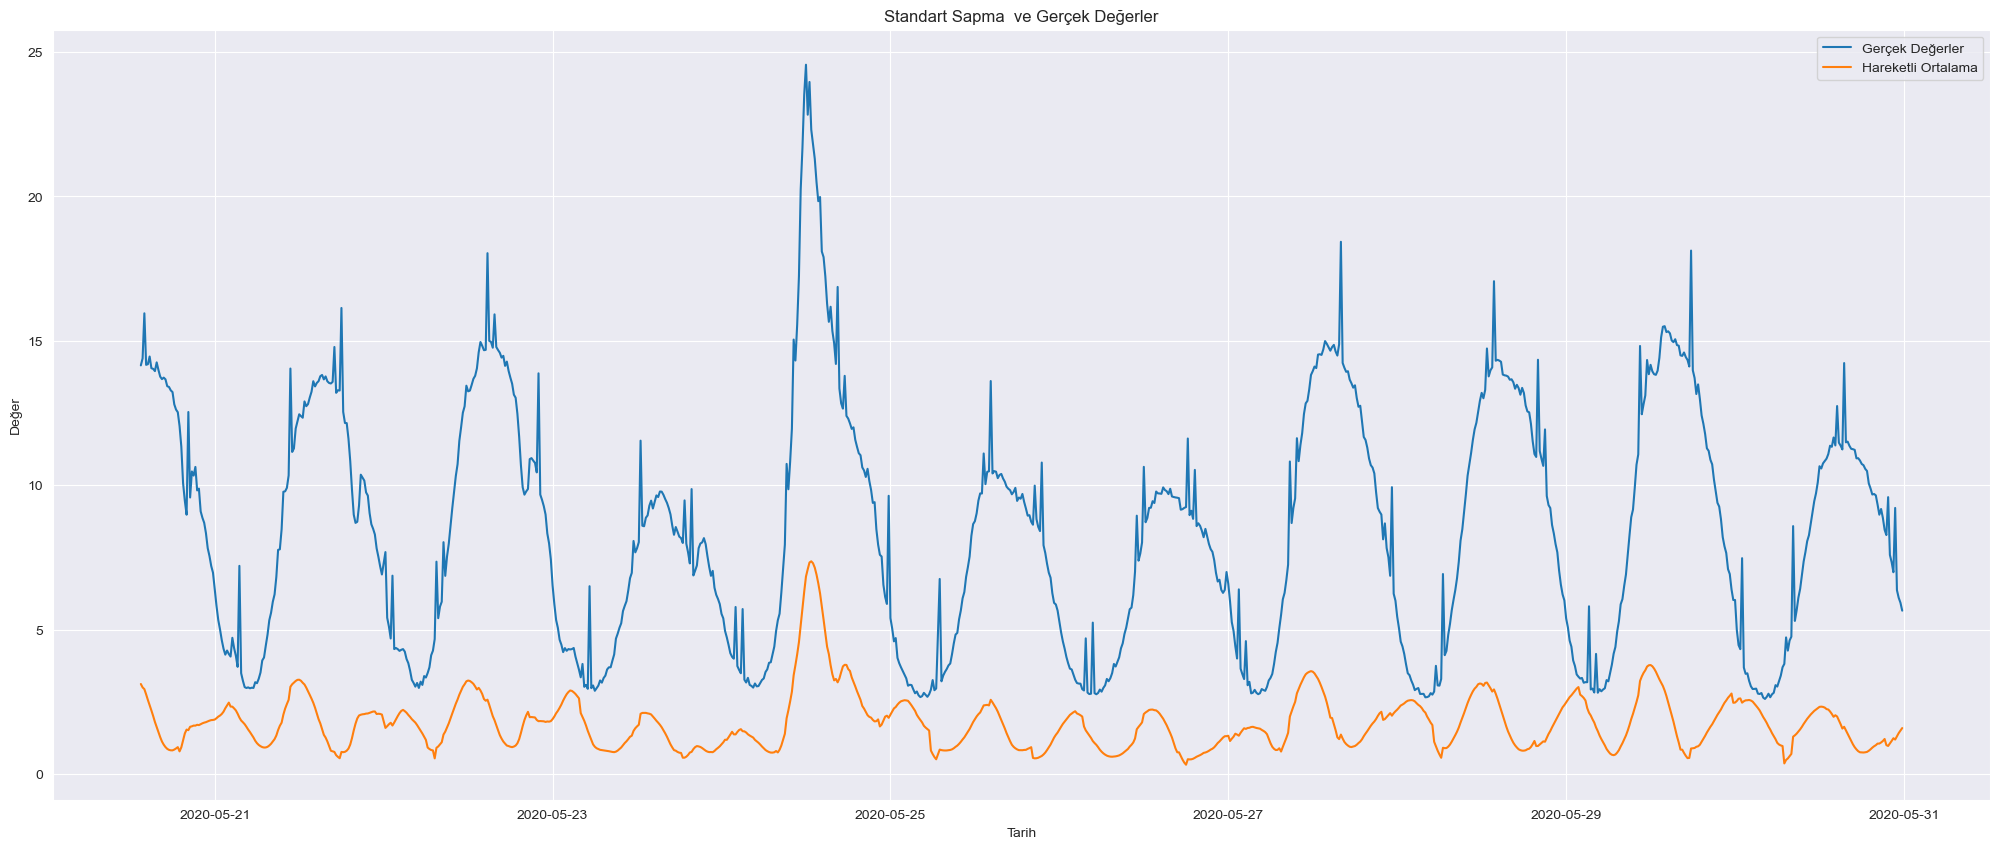

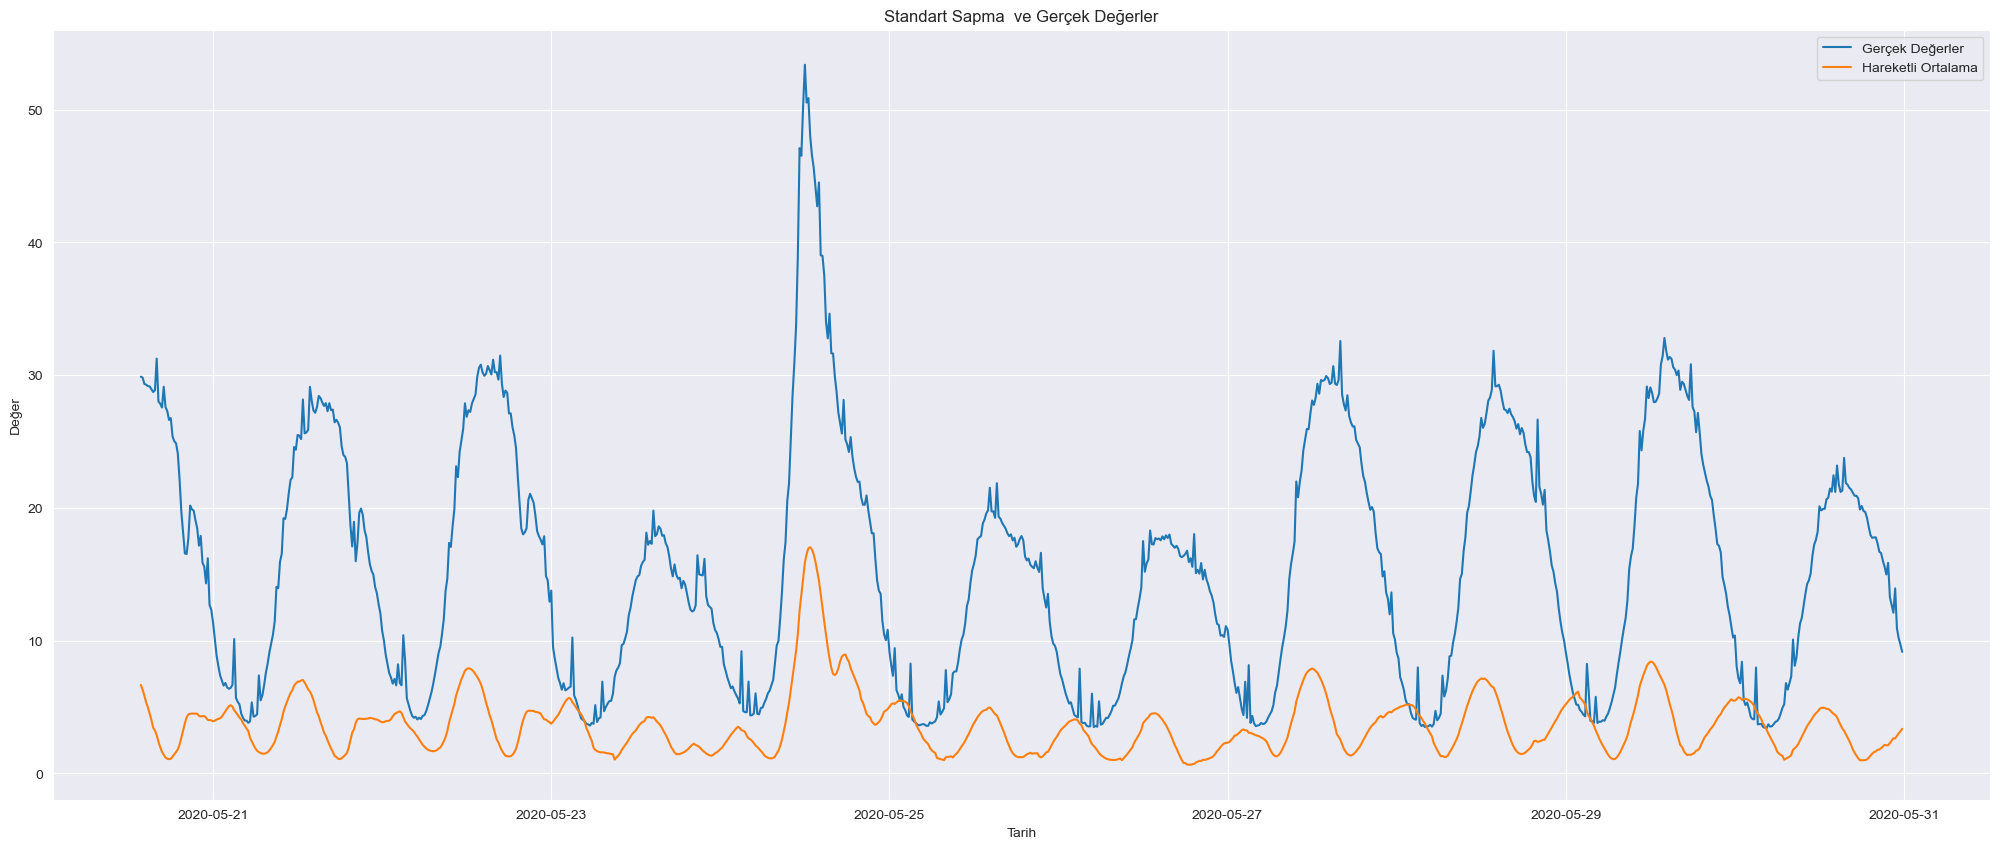

,DATETIME,CPULOAD,day,hour,hourcategory,day_name,weekday,sma_24,std_24
0,2020-03-24 00:00:00,7.084167,24,0,Night,Tuesday,True,NaN,NaN
1,2020-03-24 00:15:00,6.490833,24,0,Night,Tuesday,True,NaN,NaN
2,2020-03-24 00:30:00,5.668750,24,0,Night,Tuesday,True,NaN,NaN
3,2020-03-24 00:45:00,5.371250,24,0,Night,Tuesday,True,NaN,NaN
4,2020-03-24 01:00:00,5.005417,24,1,Night,Tuesday,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6509,2020-05-30 22:45:00,13.932917,30,22,Evening,Saturday,False,17.339132,2.632235
6510,2020-05-30 23:00:00,10.920833,30,23,Evening,Saturday,False,16.922969,2.825774
6511,2020-05-30 23:15:00,10.177917,30,23,Evening,Saturday,False,16.475747,3.010447
6512,2020-05-30 23:30:00,9.696667,30,23,Evening,Saturday,False,16.016215,3.171012


In [32]:
predict_std(server_301,24)
predict_std(server_305,24)

## modellemeye hazırlık

dataframelerin son haline bakalım;

In [33]:
check_df(server_301)

**** Genel Bilgiler ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATETIME      6515 non-null   datetime64[ns]
 1   CPULOAD       6515 non-null   float64       
 2   day           6515 non-null   int64         
 3   hour          6515 non-null   int64         
 4   hourcategory  6515 non-null   object        
 5   day_name      6515 non-null   object        
 6   weekday       6515 non-null   bool          
 7   sma_24        6492 non-null   float64       
 8   std_24        6492 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 413.7+ KB
None
**** Eksik değer var mı ****
DATETIME         0
CPULOAD          0
day              0
hour             0
hourcategory     0
day_name         0
weekday          0
sma_24          23
std_24          23
dtype: int64
**** ilk 

In [34]:
check_df(server_305)

**** Genel Bilgiler ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6514 entries, 0 to 6513
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATETIME      6514 non-null   datetime64[ns]
 1   CPULOAD       6514 non-null   float64       
 2   day           6514 non-null   int64         
 3   hour          6514 non-null   int64         
 4   hourcategory  6514 non-null   object        
 5   day_name      6514 non-null   object        
 6   weekday       6514 non-null   bool          
 7   sma_24        6491 non-null   float64       
 8   std_24        6491 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 413.6+ KB
None
**** Eksik değer var mı ****
DATETIME         0
CPULOAD          0
day              0
hour             0
hourcategory     0
day_name         0
weekday          0
sma_24          23
std_24          23
dtype: int64
**** ilk 

yeni türettiğimiz kategorik değişkenlere One Hot Encoding uygulamamız gerekir.
ayrıca türettiğimiz sma ve std değişkenleri kurulacak modelde data leakage (veri sızıntısına sebep olacağından modelin dışında tutalım )

In [35]:
#sayısal ve binary değişkenleri train isimli eğitim setine ekleme
train_301 = server_301[["DATETIME","CPULOAD","day","hour","weekday"]]
train_301['weekday'] = train_301['weekday'].astype(int)

#kategorik değişkenleri one hot encoding yöntemiyle yeni değişkenlere çevirme ve train setiyle birleştirme
ohe_data_301 = pd.get_dummies(server_301[["hourcategory","day_name"]])
train_301 = pd.concat([train_301, ohe_data_301], axis=1)

train_301

,DATETIME,CPULOAD,day,hour,weekday,hourcategory_Day,hourcategory_Evening,hourcategory_Night,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
0,2020-03-24 00:00:00,4.425000,24,0,1,0,0,1,0,0,0,0,0,1,0
1,2020-03-24 00:15:00,4.427500,24,0,1,0,0,1,0,0,0,0,0,1,0
2,2020-03-24 00:30:00,3.910417,24,0,1,0,0,1,0,0,0,0,0,1,0
3,2020-03-24 00:45:00,3.633750,24,0,1,0,0,1,0,0,0,0,0,1,0
4,2020-03-24 01:00:00,3.575000,24,1,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,2020-05-30 22:45:00,9.213333,30,22,0,0,1,0,0,0,1,0,0,0,0
6511,2020-05-30 23:00:00,6.367083,30,23,0,0,1,0,0,0,1,0,0,0,0
6512,2020-05-30 23:15:00,6.102083,30,23,0,0,1,0,0,0,1,0,0,0,0
6513,2020-05-30 23:30:00,5.930833,30,23,0,0,1,0,0,0,1,0,0,0,0


In [36]:
train_301

,DATETIME,CPULOAD,day,hour,weekday,hourcategory_Day,hourcategory_Evening,hourcategory_Night,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
0,2020-03-24 00:00:00,4.425000,24,0,1,0,0,1,0,0,0,0,0,1,0
1,2020-03-24 00:15:00,4.427500,24,0,1,0,0,1,0,0,0,0,0,1,0
2,2020-03-24 00:30:00,3.910417,24,0,1,0,0,1,0,0,0,0,0,1,0
3,2020-03-24 00:45:00,3.633750,24,0,1,0,0,1,0,0,0,0,0,1,0
4,2020-03-24 01:00:00,3.575000,24,1,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,2020-05-30 22:45:00,9.213333,30,22,0,0,1,0,0,0,1,0,0,0,0
6511,2020-05-30 23:00:00,6.367083,30,23,0,0,1,0,0,0,1,0,0,0,0
6512,2020-05-30 23:15:00,6.102083,30,23,0,0,1,0,0,0,1,0,0,0,0
6513,2020-05-30 23:30:00,5.930833,30,23,0,0,1,0,0,0,1,0,0,0,0


In [37]:
#sayısal ve binary değişkenleri train isimli eğitim setine ekleme
train_305 = server_305[["DATETIME","CPULOAD","day","hour","weekday"]]
train_305['weekday'] = train_305['weekday'].astype(int)

train_305.dropna(inplace=True)

#kategorik değişkenleri one hot encoding yöntemiyle yeni değişkenlere çevirme ve train setiyle birleştirme
ohe_data_305 = pd.get_dummies(server_305[["hourcategory","day_name"]])
train_305 = pd.concat([train_305, ohe_data_305], axis=1)
#train_305 = train_305.drop(y.index[-1])
train_305

,DATETIME,CPULOAD,day,hour,weekday,hourcategory_Day,hourcategory_Evening,hourcategory_Night,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
0,2020-03-24 00:00:00,7.084167,24,0,1,0,0,1,0,0,0,0,0,1,0
1,2020-03-24 00:15:00,6.490833,24,0,1,0,0,1,0,0,0,0,0,1,0
2,2020-03-24 00:30:00,5.668750,24,0,1,0,0,1,0,0,0,0,0,1,0
3,2020-03-24 00:45:00,5.371250,24,0,1,0,0,1,0,0,0,0,0,1,0
4,2020-03-24 01:00:00,5.005417,24,1,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6509,2020-05-30 22:45:00,13.932917,30,22,0,0,1,0,0,0,1,0,0,0,0
6510,2020-05-30 23:00:00,10.920833,30,23,0,0,1,0,0,0,1,0,0,0,0
6511,2020-05-30 23:15:00,10.177917,30,23,0,0,1,0,0,0,1,0,0,0,0
6512,2020-05-30 23:30:00,9.696667,30,23,0,0,1,0,0,0,1,0,0,0,0


In [41]:
def xgb_modelling(df, params=None):
    y = df['CPULOAD']
    X = df.drop(["CPULOAD","DATETIME"],axis=1)
    X.dropna(inplace=True)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15 , random_state=42, shuffle=False)
    xgb_deneme = XGBRegressor(**params)
    xgb_deneme.fit(X_train,y_train)
    # Test seti üzerinde tahmin yapma
    y_pred = xgb_deneme.predict(X_test)

    # Hata ölçeğini mae olarak hesaplama
    mae = mean_absolute_error(y_test, y_pred)

    # MAE değerini yazdırma
    print('MAE: ',format(mae))

In [42]:
default_params = {"n_estimators":3000 , "max_depth": 7 , "learning_rate": 0.01 , "gamma": 1 , "colsample_bytree": 0.6 , "subsample":0.6}

In [43]:
xgb_modelling(train_305,default_params)

MAE:  3.614593154365056


In [44]:
xgb_modelling(train_301,default_params)

MAE:  1.6820533837277467


In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [106]:
def random_search(df):
    y = df['CPULOAD']
    X = df.drop(["CPULOAD","DATETIME"],axis=1)
    base_model = XGBRegressor()
    params = {
        'n_estimators': np.arange(1500, 3000, 25),
        'learning_rate': np.logspace(-4, 0, 40),
        'max_depth': np.arange(2, 30),
        'subsample': np.arange(0.1, 1.1, 0.1),
        'colsample_bytree': np.arange(0.1, 1.1, 0.1),
        'gamma': np.arange(0, 10),
        'reg_alpha': [0, 0.1, 0.5, 1.0],  # Belirli değerler arasında
        'reg_lambda': [0, 0.1, 0.5, 1.0]
     }

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    random_search = RandomizedSearchCV(base_model, param_distributions= params, n_iter= 100, cv= 3, scoring= mae_scorer , random_state= 53)
    random_search.fit(X , y)

    print(f"""
          En iyi XGB parametreleri : {random_search.best_params_}
          En iyi maee skorumuz : {-random_search.best_score_}
          """)
    return random_search.best_params_

In [107]:
best_params_301 = random_search(train_301)


          En iyi XGB parametreleri : {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 2400, 'max_depth': 3, 'learning_rate': 0.002154434690031882, 'gamma': 6, 'colsample_bytree': 0.6000000000000001}
          En iyi maee skorumuz : 1.0951208896015667
          


In [108]:
best_params_305 = random_search(train_305)


          En iyi XGB parametreleri : {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 2400, 'max_depth': 3, 'learning_rate': 0.002154434690031882, 'gamma': 6, 'colsample_bytree': 0.6000000000000001}
          En iyi maee skorumuz : 2.228084631039589
          


test veri setini hazırlamak

In [109]:
test_df['DATETIME'] = pd.to_datetime(test_df['DATETIME'], format='%Y-%m-%dT%H:%M')
test_df['DATETIME'] = test_df['DATETIME'].dt.tz_localize(None)

In [110]:
test_305 = test_df[test_df["SERVER"]=="CIHAZ_305"]
test_301 = test_df[test_df["SERVER"]=="CIHAZ_301"]

In [111]:
test_301 = time_features(test_301)
test_305 = time_features(test_305)

In [112]:
test_301 = weekend_c(test_301)
test_305 = weekend_c(test_305)

In [113]:
ohe_test_301 = pd.get_dummies(test_301[["hourcategory","day_name"]])
test_301 = pd.concat([test_301, ohe_test_301], axis=1)

ohe_test_305 = pd.get_dummies(test_305[["hourcategory","day_name"]])
test_305 = pd.concat([test_305, ohe_test_305], axis=1)

In [114]:
test_301["CPULOAD"] = float("nan")
test_305["CPULOAD"] = float("nan")

In [115]:
test_305[["day_name_Monday","day_name_Tuesday","day_name_Wednesday","day_name_Thursday","day_name_Friday","day_name_Saturday"]] = 0

test_305.drop(["SERVER","hourcategory",'day_name',"index"],axis = 1, inplace = True)
test_305['weekday'] = test_305['weekday'].astype(int)

In [116]:
test_301[["day_name_Monday","day_name_Tuesday","day_name_Wednesday","day_name_Thursday","day_name_Friday","day_name_Saturday"]] = 0

test_301.drop(["SERVER","hourcategory",'day_name',"index"],axis = 1, inplace = True)
test_301['weekday'] = test_301['weekday'].astype(int)

In [117]:
def xgb_final(df,test,params):
    y = df['CPULOAD']
    X = df.drop(["CPULOAD","DATETIME"],axis=1)
    test = test.drop(["CPULOAD","DATETIME"],axis=1)
    xgb_deneme = XGBRegressor(**params)
    xgb_deneme.fit(X,y)
    columns_order = X.columns
    test = test.reindex(columns=columns_order)
    # Test seti üzerinde tahmin yapma
    y_pred = xgb_deneme.predict(test)
    return y_pred

In [118]:
y_pred_301  =  xgb_final(train_301,test_301,best_params_301)

In [119]:
y_pred_305  =  xgb_final(train_305,test_305,best_params_305)

In [120]:
y_pred_301_df = pd.DataFrame(index=np.arange(0,192,2),data = y_pred_301)
y_pred_305_df = pd.DataFrame(index=np.arange(1,192,2),data = y_pred_305)

In [121]:
y_pred_301_df

,0
0,4.489104
2,4.489104
4,4.489104
6,4.489104
8,3.649371
...,...
182,6.805217
184,5.768270
186,5.768270
188,5.768270


In [122]:
y_pred_305_df

,0
1,6.616110
3,6.616110
5,6.616110
7,6.616110
9,5.059673
...,...
183,11.523788
185,9.374375
187,9.374375
189,9.374375


In [123]:
sub = pd.concat([y_pred_301_df,y_pred_305_df], axis=0).sort_index()

In [124]:
sample_submission["CPULOAD"] = sub

In [125]:
sample_submission

,index,CPULOAD
0,0,4.489104
1,1,6.616110
2,2,4.489104
3,3,6.616110
4,4,4.489104
...,...,...
187,187,9.374375
188,188,5.768270
189,189,9.374375
190,190,5.768270


In [126]:
sample_submission.to_csv('sample_submission.csv',index=False)